# 4. 시계열 (전처리, 탐색적 분석, 모델링)

## [연습문제]

### 1. 다음은 Microsoft의 주식 가격 데이터이다. 데이터는 날짜와 주식 종가로 구성되어 있다. 다음 데이터를 주 단위 평균 가격으로 다운샘플링하고, 앞의 데이터 300개를 down_head, 뒤의 데이터 14개를 down_tail로 분할하시오. (데이터 링크는 아래 코드 참조)

In [1]:
from pandas import read_csv
ms = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice12_ms_stock.csv', encoding='euc-kr')
ms['Date'] = ms['Date'
               ].astype('datetime64')
ms = ms.set_index('Date')
ms

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [6]:
down = ms.resample('W').mean()
print(down)

down_head = down.head(300)
down_tail = down.tail(14)

                 Close
Date                  
2015-04-05   40.505000
2015-04-12   41.540000
2015-04-19   41.890000
2015-04-26   43.950000
2015-05-03   48.710000
...                ...
2021-03-07  231.340000
2021-03-14  233.294000
2021-03-21  234.126000
2021-03-28  235.570000
2021-04-04  234.286667

[314 rows x 1 columns]


### 2. down_head 데이터로 탐색적 분석을 진행하시오.

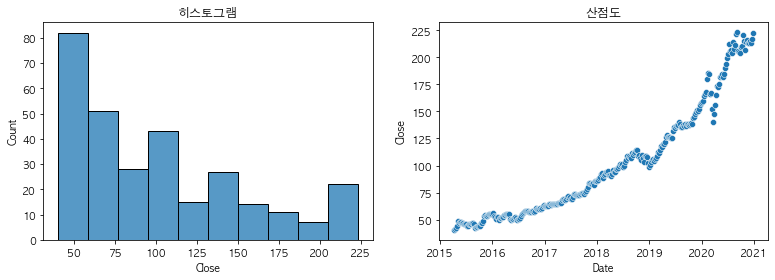


 [요약통계량]
       count    mean    std   min    25%    50%     75%    max
Close  300.0  101.73  51.32  40.5  57.51  90.93  136.58  223.2


In [8]:
# 일반적 EDA
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes[0].set_title("히스토그램")
sns.histplot(x='Close', data=down_head, ax=axes[0])
axes[1].set_title("산점도")
sns.scatterplot(x='Date', y='Close', data=down_head, ax=axes[1])
plt.show()

# 요약 통계량
print("\n [요약통계량]")
print(down_head.describe().round(2).T)

ADF Statistics: 2.240, p-value: 0.999
KPSS Statistics: 2.593, p-value: 0.010


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


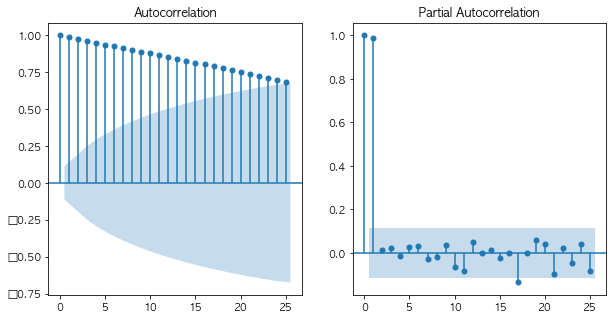

In [9]:
# 시계열에 특화된 EDA
from statsmodels.tsa.stattools import adfuller, kpss
result = adfuller(down_head, regression='c', autolag='AIC')
print("ADF Statistics: {:.3f}, p-value: {:.3f}".format(result[0], result[1]))

result = kpss(down_head, regression='c', nlags='auto')
print("KPSS Statistics: {:.3f}, p-value: {:.3f}".format(result[0], result[1]))
# ADF, KPSS 검정을 통해 시계열이 비정상임을 알 수 있다.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_acf(down_head, ax=ax[0])
plot_pacf(down_head, ax=ax[1])
plt.show()
# ACF 그래프를 통해 시계열이 비정상임을 알 수 있으며, 자기 상관이 있는 것을 알 수 있다.

In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox
result = acorr_ljungbox(down_head, return_df=True, auto_lag=True).head(3)
print(result)

from statsmodels.stats.stattools import durbin_watson
result = durbin_watson(down_head)
print(result)
# 융박스 테스트와 더빈왓슨 통계량을 통해 시계열이 자기 상관이 있는 것을 알 수 있다.

      lb_stat      lb_pvalue
1  294.753777   4.579097e-66
2  582.583051  3.116721e-127
3  863.943057  5.859132e-187
[0.00083511]


### 3. down_head 데이터로 시계열 모델을 적합하시오.

In [1305]:
# 적절한 차수 모색을 위해 auto_arima를 사용하였다.
from pmdarima import auto_arima
auto_arima(down_head, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7, seasonal=True, trace=False, error_action='warn', suppress_warnings=True)

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [1306]:
from statsmodels.tsa.arima.model import ARIMA
p, d, q = 3, 1, 2
P, D, Q, m = 1, 0, 1, 7
model = ARIMA(down_head, order=(p, d, q), seasonal_order=(P, D, Q, m))
fitted = model.fit()
print(fitted.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  300
Model:             ARIMA(3, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -770.519
Date:                           Tue, 19 Sep 2023   AIC                           1557.039
Time:                                   14:05:37   BIC                           1586.642
Sample:                               04-05-2015   HQIC                          1568.888
                                    - 12-27-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1259      0.085      1.474      0.140      -0.041       0.293
ar.L2          0.9912      0.051     19.575

### 4. 해당 모델로 down_tail의 기간의 값을 예측하고, 적절한 평가 지표를 선택하여 해당 모델을 평가 하시오.

3.5


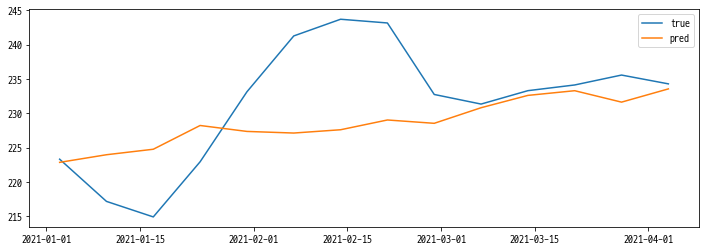

In [1325]:
# 시계열 모델을 평가하기 위한 지표로 MAPE를 사용할 수 있다. MAPE는 MAE를 퍼센트로 변환한 것으로서 예측값 대비 잔차의 비율을 의미하며 주로 다른 시계열 모형의 적합치를 비교하는데 사용한다. 값이 작을수록 적합도가 높다는 것을 의미한다.
def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

pred = fitted.predict(start=down_tail.index[0], end=down_tail.index[-1])
print(MAPE(down_tail.values, pred.values).round(2))
# 해당 모델로 down_tail 데이터의 기간을 예측한 결과, MAPE 3.5%를 얻었다. 이는 실제값과 예측값이 평균적으로 3.5% 차이난다는 의미이다.

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(down_tail, label='true')
ax.plot(pred, label='pred')
plt.legend()
plt.show()

## [기출문제]

# 1. 가구별 전력 사용량 시계열 문제
- ADP 실기 20회 문제 (https://www.datamanim.com/dataset/ADPpb/00/20.html)

In [2]:
import pandas as pd
ttt= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/20/problem2.csv')
ttt.head(3)

,houseCode,date,power consumption
0,house_01,2050-01-14 21:00:00,57.559878
1,house_26,2050-01-02 19:10:00,59.726880
2,house_25,2050-01-13 07:20:00,6.558823


### 1-1. 각 가구의 15분간격의 전력량의 합을 구하고 해당데이터를 바탕으로 총 5개의 군집으로 군집화를 진행한 후 아래의 그림과 같은 형태로 출력하라. 군집화를 위한 데이터 구성의 이유를 설명하라. (군집 방식에 따라 Cluster컬럼의 값은 달라질수 있음)
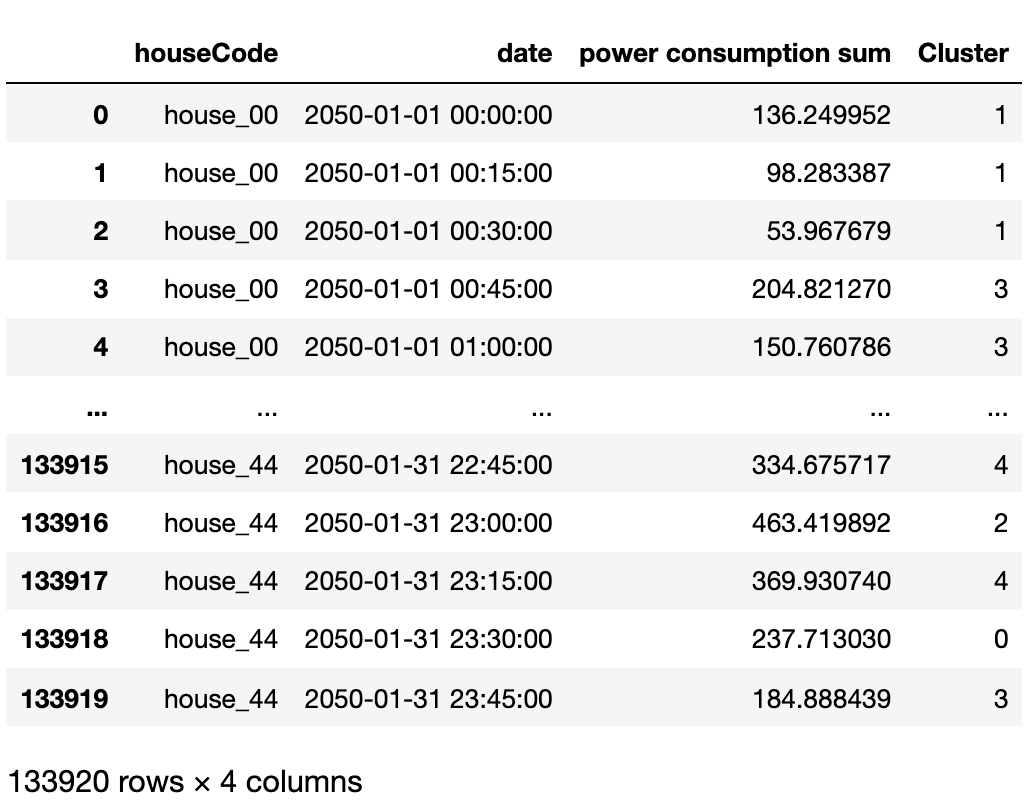

In [3]:
# 시계열 데이터로 변환
ttt['date'] = ttt['date'].astype('datetime64')
ttt = ttt.set_index('date')

In [4]:
# houseCode, date 기준으로 리샘플링
ts = ttt.groupby('houseCode').resample('15min').sum().reset_index()
ts

,houseCode,date,power consumption
0,house_00,2050-01-01 00:00:00,136.249952
1,house_00,2050-01-01 00:15:00,98.283387
2,house_00,2050-01-01 00:30:00,53.967679
3,house_00,2050-01-01 00:45:00,204.821270
4,house_00,2050-01-01 01:00:00,150.760786
...,...,...,...
133915,house_44,2050-01-31 22:45:00,334.675717
133916,house_44,2050-01-31 23:00:00,463.419892
133917,house_44,2050-01-31 23:15:00,369.930740
133918,house_44,2050-01-31 23:30:00,237.713030


In [5]:
# 전력 소비량 기준으로 군집분석 진행
ts2 = ts.copy()
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)
km.fit(ts[['power consumption']])
ts2['cluster'] = km.labels_
ts2

,houseCode,date,power consumption,cluster
0,house_00,2050-01-01 00:00:00,136.249952,3
1,house_00,2050-01-01 00:15:00,98.283387,3
2,house_00,2050-01-01 00:30:00,53.967679,3
3,house_00,2050-01-01 00:45:00,204.821270,0
4,house_00,2050-01-01 01:00:00,150.760786,0
...,...,...,...,...
133915,house_44,2050-01-31 22:45:00,334.675717,2
133916,house_44,2050-01-31 23:00:00,463.419892,1
133917,house_44,2050-01-31 23:15:00,369.930740,2
133918,house_44,2050-01-31 23:30:00,237.713030,4


### 1-2. 위의 데이터를 바탕으로 각 군집의 요일, 15분간격별 전력사용량의 합을 구한 후 아래와 같이 시각화 하여라 (수치는 동일하지 않을 수 있음 2-1의 데이터가 정확하게 아래와 같은 이미지로 변환 됐는지 주로 확인)
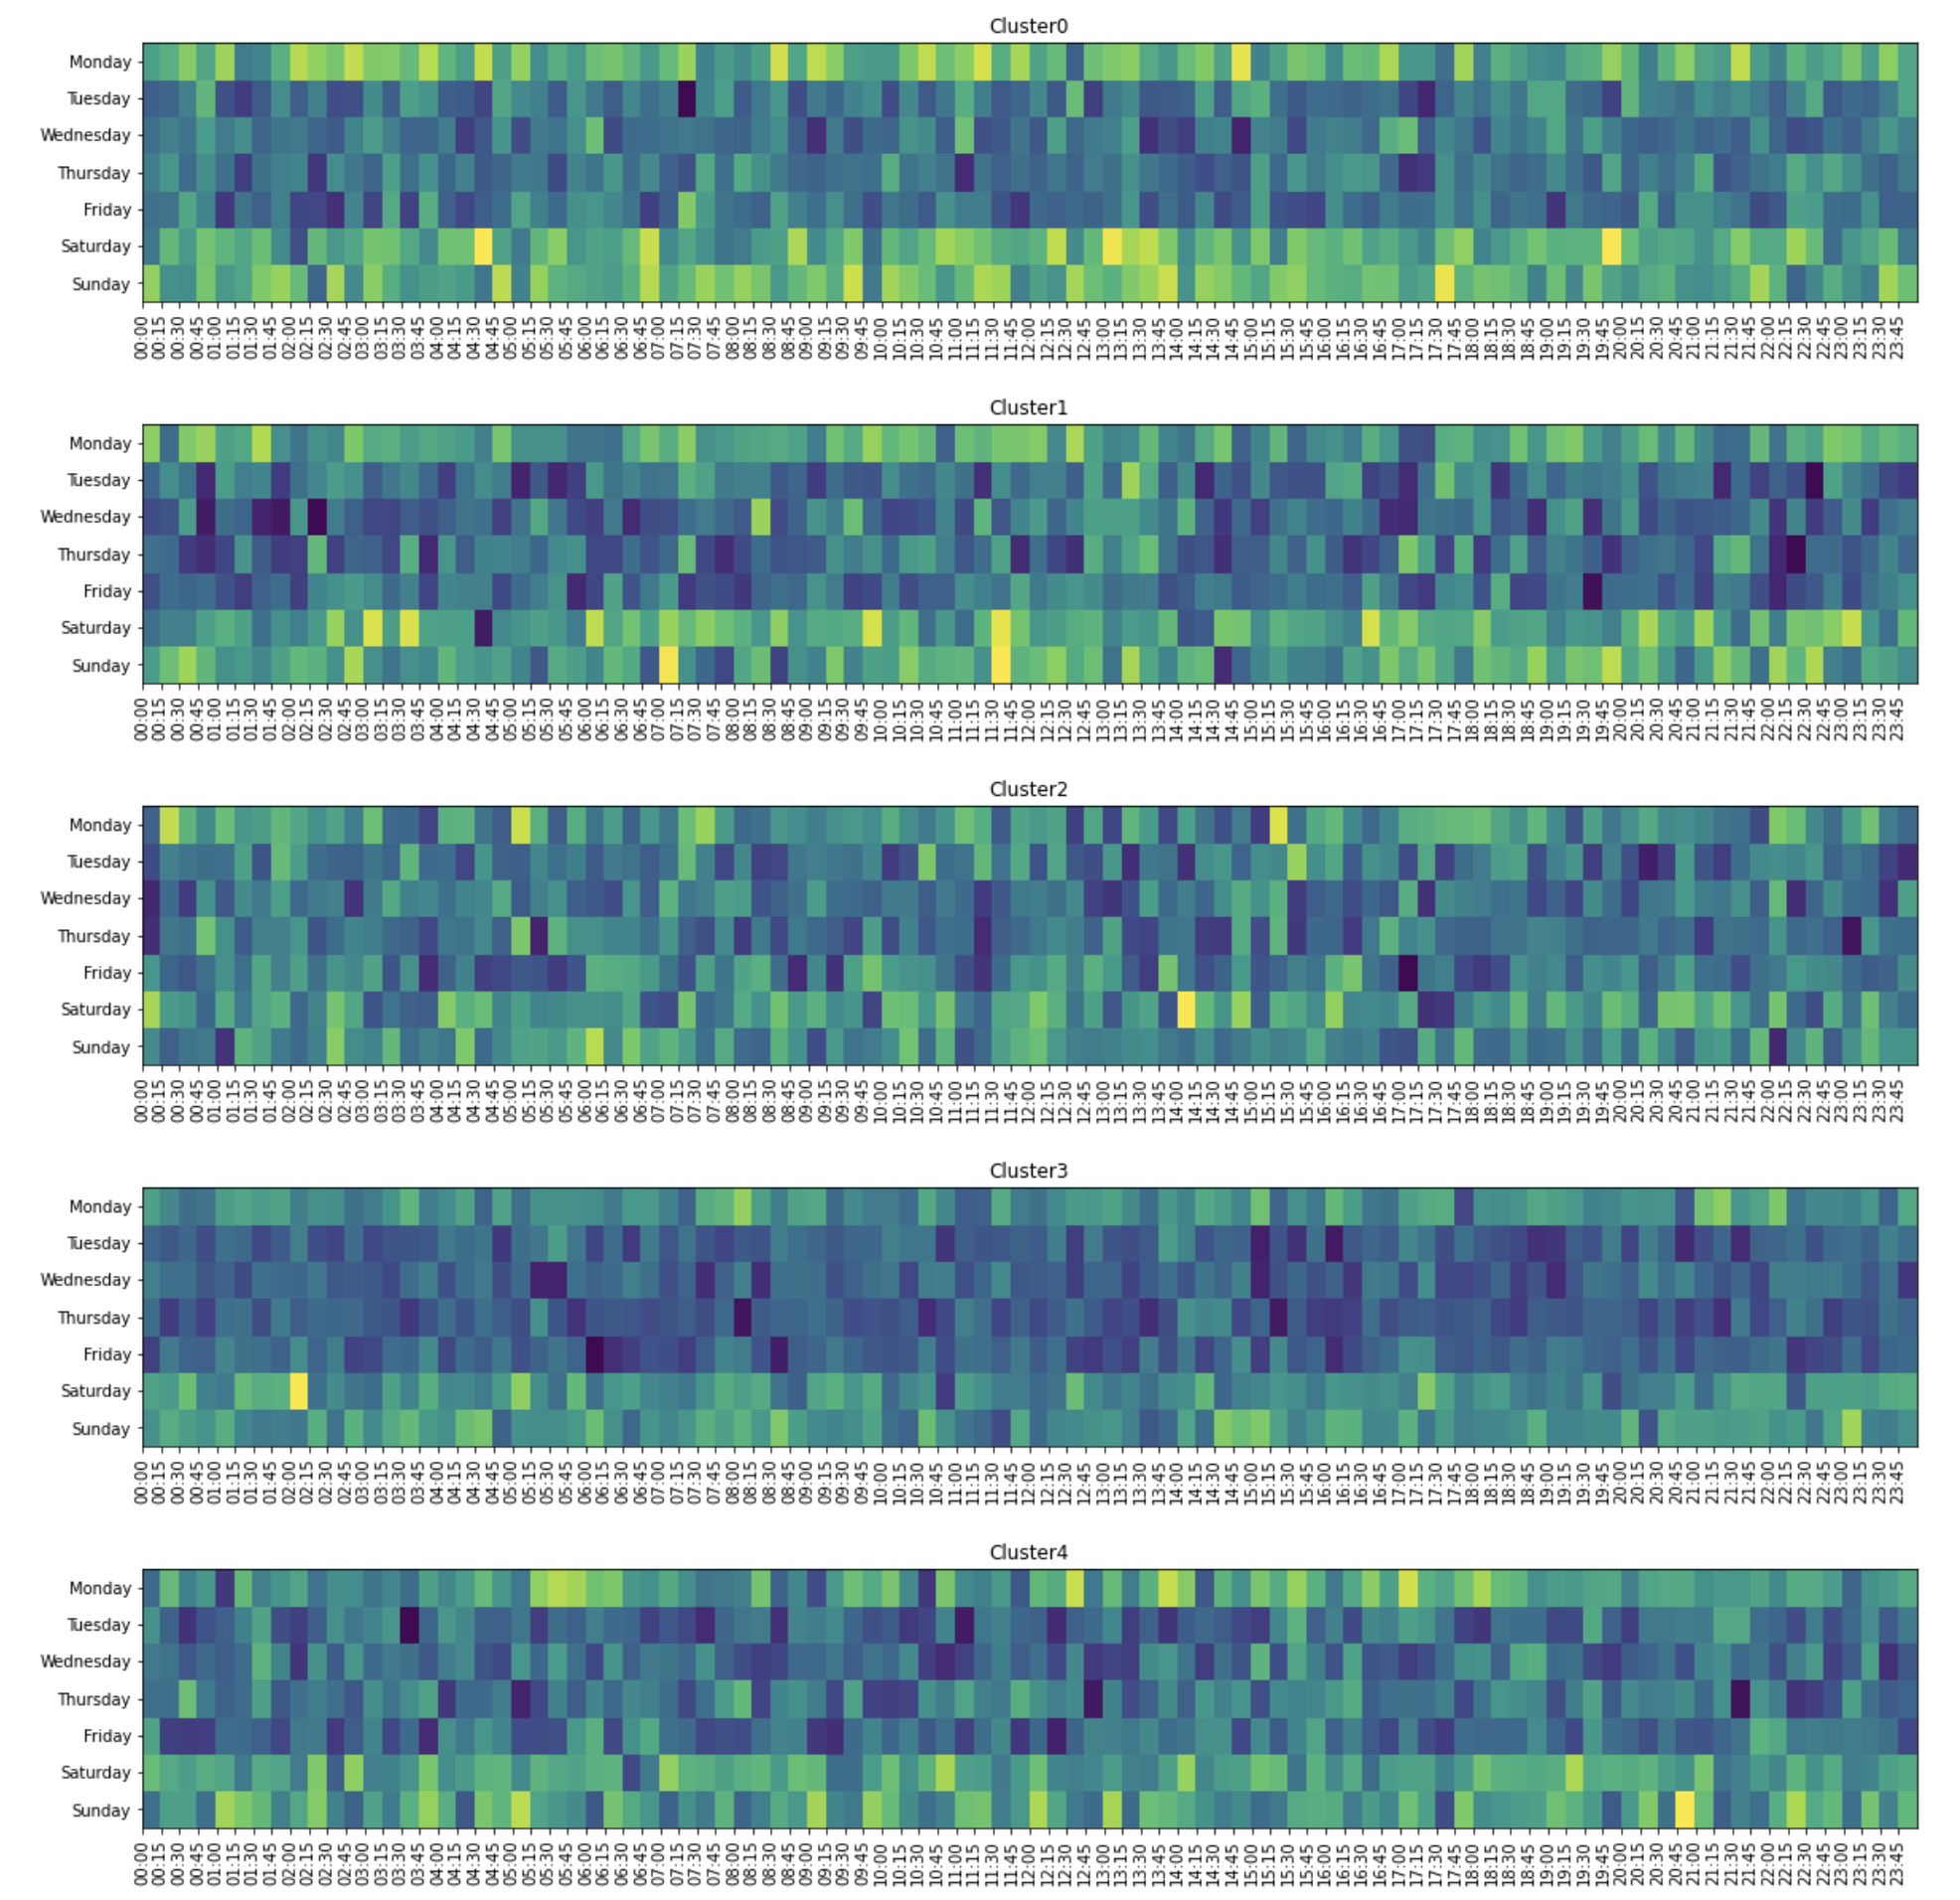

In [6]:
# date에서 weekday, HM 추출
ts2['weekday'] = ts2['date'].dt.weekday
ts2['HM'] = ts2['date'].apply(lambda x: x.strftime("%H:%M"))

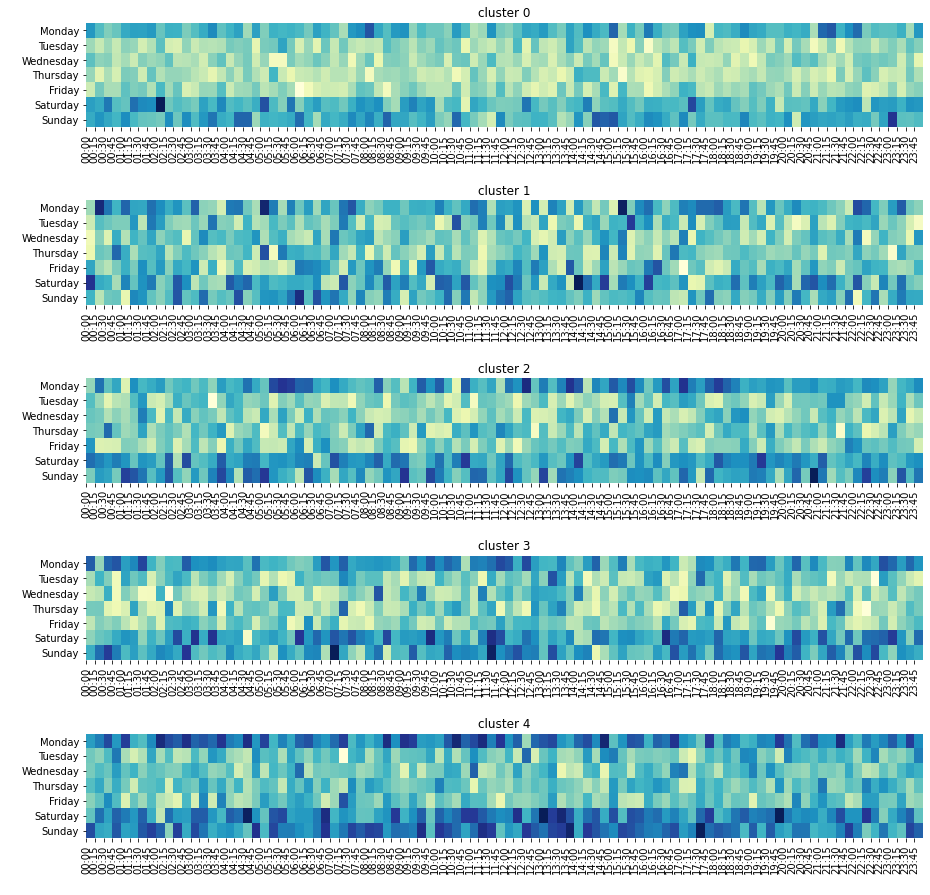

In [17]:
# cluster 별로 요일, 시각별 전력 소비량 시각화
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import crosstab

fig, axes = plt.subplots(5,1, figsize=(15,15))
plt.subplots_adjust(hspace=0.7)
for ax, cluster in zip(axes.ravel(), range(5)):
    each = ts2[ts2['cluster']==cluster].filter(['HM', 'weekday', 'power consumption'])
    ctable = crosstab(each['weekday'], each['HM'], values=each['power consumption'], aggfunc=sum)
    sns.heatmap(ctable, ax=ax, cbar=False, cmap='YlGnBu')
    ax.set_xticks([i for i in range(each['HM'].nunique())])
    ax.set_xticklabels(sorted(each['HM'].unique()))
    ax.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontdict={'rotation':0})
    ax.set_title('cluster %s' %cluster)
    ax.set_ylabel(" ")
    ax.set_xlabel(" ")
plt.show()

# 2. 나라별 코로나19 확진자 시계열 문제
- ADP 실기 17회 문제 (https://www.datamanim.com/dataset/ADPpb/00/17.html)
[데이터 설명]  
> - date : 일자
> - total_cases : 누적 확인자
> - total_deaths : 누적 사망자
> - new_tests : 검사자
> - population : 인구
> - new_vaccinations : 백신 접종자

In [18]:
import pandas as pd
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/17/problem2.csv')
df.head()

,location,date,total_cases,total_deaths,new_tests,population,new_vaccinations
0,Afghanistan,2020-02-24,5.0,NaN,NaN,39835428.0,NaN
1,Afghanistan,2020-02-25,5.0,NaN,NaN,39835428.0,NaN
2,Afghanistan,2020-02-26,5.0,NaN,NaN,39835428.0,NaN
3,Afghanistan,2020-02-27,5.0,NaN,NaN,39835428.0,NaN
4,Afghanistan,2020-02-28,5.0,NaN,NaN,39835428.0,NaN


### 2-1. 마지막 일자를 기준으로 인구 대비 확진자 비율이 높은 상위 5개 국가를 구하여라. 상위 5개 국가별로 누적 확진자, 일일 확진자, 누적 사망자, 일일 사망자, 그래프, 범례를 이용해서 가독성 있게 만들어라

In [23]:
# 시계열 데이터로 변경
df['date'] = df['date'].astype('datetime64')
lastday = sorted(df['date'].unique())[-1]

In [26]:
# 마지막 날짜를 기준으로 인구 대비 확진자 비율 계산
check = df.query("date==@lastday").groupby(['date', 'location']).sum()
check['total_cases/population'] = check['total_cases'] / check['population']
check.sort_values(by='total_cases/population', ascending=False).head(6)

total_cases  total_deaths  new_tests  population  \
date       location                                                          
2021-11-30 International        721.0          15.0        0.0         0.0   
           Montenegro        157376.0        2307.0        0.0    628051.0   
           Seychelles         23417.0         125.0        0.0     98910.0   
           Andorra            17115.0         131.0        0.0     77354.0   
           Slovakia         1170200.0       14418.0        0.0   5460726.0   
           Georgia           845643.0       12054.0        0.0   3979773.0   

                          new_vaccinations  total_cases/population  
date       location                                                 
2021-11-30 International               0.0                     inf  
           Montenegro                  0.0                0.250578  
           Seychelles                  0.0                0.236751  
           Andorra                     0.0                0.221256  
           Slovakia                    0.0                0.214294  
           Georgia                     0.0                0.212485

In [27]:
import warnings
warnings.filterwarnings('ignore')

# 상위 5개 국가 확인
top5 = ['Montenegro', 'Seychelles', 'Andorra', 'Slovakia', 'Georgia']
check2 = check.query("location in @top5")

# 마지막 날짜를 기준으로 일일 확진자 수 계산
check2['daily_cases'] = df.query("location in @top5").query("date=='2021-11-30'")['total_cases'].values - df.query("location in @top5").query("date=='2021-11-29'")['total_cases'].values

# 마지막 날짜를 기준으로 일일 사망자 수 계산
check2['daily_deaths'] = df.query("location in @top5").query("date=='2021-11-30'")['total_deaths'].values - df.query("location in @top5").query("date=='2021-11-29'")['total_deaths'].values

check2

total_cases  total_deaths  new_tests  population  \
date       location                                                       
2021-11-30 Andorra         17115.0         131.0        0.0     77354.0   
           Georgia        845643.0       12054.0        0.0   3979773.0   
           Montenegro     157376.0        2307.0        0.0    628051.0   
           Seychelles      23417.0         125.0        0.0     98910.0   
           Slovakia      1170200.0       14418.0        0.0   5460726.0   

                       new_vaccinations  total_cases/population  daily_cases  \
date       location                                                            
2021-11-30 Andorra                  0.0                0.221256        403.0   
           Georgia                  0.0                0.212485       5050.0   
           Montenegro               0.0                0.250578        291.0   
           Seychelles               0.0                0.236751         27.0   
           Slovakia                 0.0                0.214294      10433.0   

                       daily_deaths  
date       location                  
2021-11-30 Andorra              0.0  
           Georgia             80.0  
           Montenegro           7.0  
           Seychelles           0.0  
           Slovakia            77.0

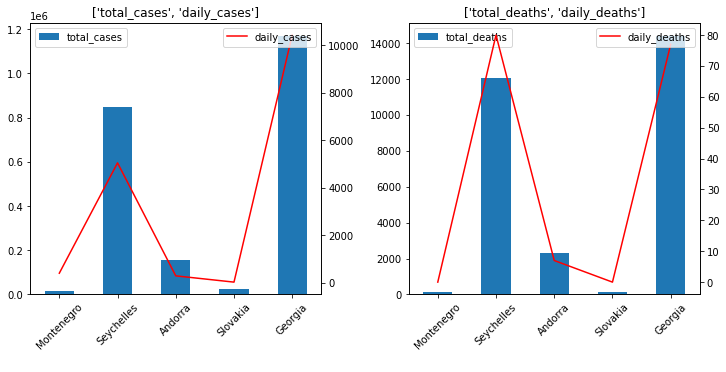

In [28]:
# 마지막 날짜의 누적 확진자, 일일 확진자, 누적 사망자, 일일 사망자 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)
feats = [['total_cases', 'daily_cases'], ['total_deaths', 'daily_deaths']]
for ax, feat in zip(axes, feats):
    ax2 = ax.twinx()
    check2[feat[0]].plot.bar(ax=ax)
    check2[feat[1]].plot(ax=ax2, color='red')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_xticklabels(top5, rotation=45)
    ax.set_xlabel(" ")
    ax.set_title(feat)
plt.show()

### 2-2. 코로나 위험지수를 직접 만들고 그 위험지수에 대한 설명을 적고 위험지수가 높은 국가들 10개를 선정해서 시각화

In [29]:
# 현재 데이터를 기반으로 전체확진자수 대비 사망자수에 대한 위험지수를 생성하였다. 해당 위험지수가 높을 수록 확진자수 대비 사망자수가 많이 발생한다는 의미이고, 해당 국가에서 코로나에 대한 치료, 방역, 관리 체계가 제대로 이루어지지 않고 있다는 것을 의미한다.
df2 = df.copy()
df2['INDEX'] = df2['total_deaths'] / df2['total_cases']
df2.query('date>="2021-11-30"')[['location', 'INDEX']].sort_values(by='INDEX', ascending=False).head(10)

,location,INDEX
135686,Yemen,0.194922
132222,Vanuatu,0.166667
98156,Peru,0.089957
80606,Mexico,0.075671
117327,Sudan,0.073322
35799,Ecuador,0.063109
112756,Somalia,0.057656
36455,Egypt,0.057098
119887,Syria,0.057069
120572,Taiwan,0.051081


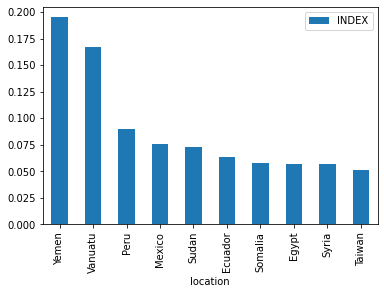

In [30]:
df2.query('date>="2021-11-30"')[['location', 'INDEX']].sort_values(by='INDEX', ascending=False).head(10).set_index('location').plot.bar()
plt.show()

### 2-3. 한국의 코로나 신규 확진자 예측해라(선형 시계열모델 + 비선형시계열 각각 한개씩 만들어라) 선형시계열 - arma 비선형 시계열 - arima

In [31]:
kor = df[df['location']=='South Korea'][['date', 'total_cases']].set_index('date').fillna(0)
kor['daily_cases'] = kor['total_cases'].diff(1).fillna(0)
kor

,total_cases,daily_cases
date,,
2020-01-21,0.0,0.0
2020-01-22,1.0,1.0
2020-01-23,1.0,0.0
2020-01-24,2.0,1.0
2020-01-25,2.0,0.0
...,...,...
2021-11-26,436968.0,4067.0
2021-11-27,440896.0,3928.0
2021-11-28,444200.0,3304.0


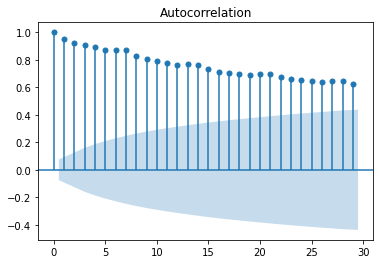

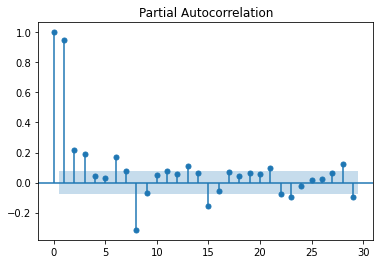

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(kor['daily_cases'])
plt.show()
plot_pacf(kor['daily_cases'])
plt.show()
# PACF에서 lag4에서 절단점을 가지므로 p, d, q = 3, 0, 0 의 AR(3) 모델로 적합
# ARMA는 둘다 가파른 절단이 없어야 함

In [122]:
from statsmodels.tsa.arima.model import ARIMA

# AR 모델
p, d, q = 3, 0, 0
model = ARIMA(kor['daily_cases'], order=(p, d, q), freq='D')
fitted1 = model.fit()
pred1 = fitted1.forecast(10) #이후 10개 날짜의 값을 예측
print(fitted1.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:            daily_cases   No. Observations:                  680
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -4469.127
Date:                Sat, 28 Oct 2023   AIC                           8948.253
Time:                        20:12:52   BIC                           8970.864
Sample:                    01-21-2020   HQIC                          8957.005
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        665.2266   4111.345      0.162      0.871   -7392.862    8723.315
ar.L1          0.9712      0.029     33.241      0.000       0.914       1.028
ar.L2         -0.3469      0.040     -8.624      0.0

In [33]:
from pmdarima import auto_arima
auto_arima(kor['daily_cases'], start_p=1, start_q=1, max_p=5, max_q=5)

ARIMA(order=(5, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [41]:
# ARIMA 모델
import datetime as dt
p, d, q = 5, 2, 3
model = ARIMA(kor['daily_cases'], order=(p, d, q), freq='D')
fitted2 = model.fit()
pred2 = fitted2.forecast(10) #이후 10개 날짜의 값을 예측
print(fitted2.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:            daily_cases   No. Observations:                  680
Model:                 ARIMA(5, 2, 3)   Log Likelihood               -4322.467
Date:                Sat, 28 Oct 2023   AIC                           8662.935
Time:                        09:14:12   BIC                           8703.607
Sample:                    01-21-2020   HQIC                          8678.680
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4620      0.042     10.940      0.000       0.379       0.545
ar.L2         -0.8307      0.043    -19.213      0.000      -0.915      -0.746
ar.L3         -0.0967      0.054     -1.792      0.0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


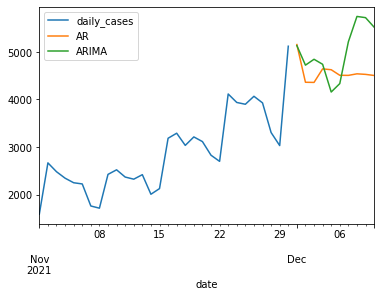

In [145]:
kor[['daily_cases']].tail(30).plot()
pred1.plot(label='AR')
pred2.plot(label='ARIMA')
plt.legend()
plt.show()

# 3. 5유형의 전력사용량 시계열 문제
### 데이터 설명
> - 데이터 설명 : 2050년 1년동안의 5유형(A,B,C,D,E)의 전력사용량을 나타낸다. 각유형의 전력사용량은 1분마다 갱신되며 그 값은 누적된다. 6시간이 지나면(00:00, 06:00, 12:00, 18:00시에) 전력사용량은 0으로 초기화 된다.
> - **problem2_usage.csv**: 6시간 간격의 총 전력사용량의 데이터이다. timestamp순서는 섞여있다. 6시간 간격의 특정 시간대(마지막시각 ‘05:59’,’11:59’,’17:59’,’23:59’)의 전력 총합을 나타낸다. 데이터의 총합을 구해서 비교할때 부동소수점 오류가 날수 있다. 파이썬의 경우 round(4)를 취하여 해결한다.
> - **problem2_usage_history.csv**: 1분간격의 A,B,C,D,E 유형의 소비 누적 전력을 나타낸다. 같은 6시간간격의 시간대의 데이터는 같은 “6hour_index”값을 가진다. 00:00, 06:00, 12:00, 18:00시에는 5유형의 전력은 초기화 된다. 데이터의 총합을 구해서 비교할때 부동소수점 오류가 날수 있다. 파이썬의 경우 round(4)를 취하여 해결한다.
> - **problem2_avg_tem.csv**: 2050년 1년동안 일자별 평균 온도를 나타낸다
- 출처: https://www.datamanim.com/dataset/ADPpb/00/15.html

In [146]:
import pandas as pd
usage =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/15/problem2_usage.csv')

usage_history =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/15/problem2_usage_history.csv')

avg_temp = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/15/problem2_avg_tem.csv')

### 3-1. usage의 총사용량을 아래와 같은 모양으로 연월별 총합으로 계산하여 CSV 파일로 작성하시오
- 일자별 총사용량은 누적사용량이 갱신되기 직전의 최대값들의 합으로 계산한다
- [‘05:59’,’11:59’,’17:59’,’23:59’] 시간대의 A,B,C,D,E의 컬럼별 총합이 각 유형의 일일 사용량이다
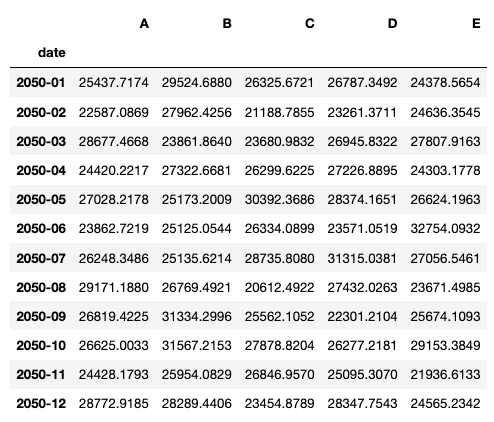

In [173]:
#한국시간 기준으로 변환
sorted(usage['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x, pytz.timezone('Asia/Seoul'))))[:5],
sorted(usage['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x)))[:5]

[Timestamp('2050-01-01 14:59:00'),
 Timestamp('2050-01-01 20:59:00'),
 Timestamp('2050-01-02 02:59:00'),
 Timestamp('2050-01-02 08:59:00'),
 Timestamp('2050-01-02 14:59:00')]

In [170]:
#utc 기준으로 변환
sorted(usage['timestamp'].apply(lambda x: dt.datetime.utcfromtimestamp(x)))[:5] 
sorted(to_datetime(usage['timestamp'], unit='s'))[:5]

[Timestamp('2050-01-01 05:59:00'),
 Timestamp('2050-01-01 11:59:00'),
 Timestamp('2050-01-01 17:59:00'),
 Timestamp('2050-01-01 23:59:00'),
 Timestamp('2050-01-02 05:59:00')]

In [63]:
## 참고
import datetime as dt
import time
usage['timestamp'] = usage['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x)) #dt객체로 변경
usage = usage.sort_values(by='timestamp').reset_index().drop('index', axis=1) #오름차순 정렬
usage
# timestamp를 변환해서 사용하면 날짜가 데이터 조건과 맞지 않음 (timestamp변환값을 무시하기로 함)

,timestamp,usage
0,2050-01-01 14:59:00,1654.2596
1,2050-01-01 20:59:00,1426.9071
2,2050-01-02 02:59:00,1448.2517
3,2050-01-02 08:59:00,1338.0897
4,2050-01-02 14:59:00,1567.5820
...,...,...
1455,2050-12-31 08:59:00,830.1747
1456,2050-12-31 14:59:00,1353.2138
1457,2050-12-31 20:59:00,841.3836
1458,2051-01-01 02:59:00,1439.1423


In [73]:
# usage 데이터 정렬해서 usuage_history와 비교
usage =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/15/problem2_usage.csv')
usage.sort_values(by='timestamp')

,timestamp,usage
654,2524629540,1654.2596
255,2524651140,1426.9071
1327,2524672740,1448.2517
671,2524694340,1338.0897
379,2524715940,1567.5820
...,...,...
1319,2556057540,830.1747
1162,2556079140,1353.2138
1267,2556100740,841.3836
1120,2556122340,1439.1423


In [48]:
#위의 usage와 usage_history의 특정시간 데이터가 동일함을 확인
sum_time=['05:59','11:59','17:59','23:59']
usage_history["hh:mm"] = usage_history["hh:mm"].astype("string")
usage_history[usage_history["hh:mm"].isin(sum_time)].sum(axis=1)

359       1654.2596
719       1426.9071
1079      1448.2517
1439      1338.0897
1799      1567.5820
            ...    
524159     830.1747
524519    1353.2138
524879     841.3836
525239    1439.1423
525599    1874.0501
Length: 1460, dtype: float64

In [101]:
# usage_history에 dates를 입력
# 문제 조건에 맞는 2050년 1년치 dates 생성
from pandas import date_range
usage_history2 = usage_history[usage_history["hh:mm"].isin(sum_time)] #특정시간 데이터만 추출
dates = date_range('2050-01-01 05:59', '2050-12-31 23:59', freq='6h')
usage_history2['date'] = dates
usage_history2['YM'] = usage_history2['date'].apply(lambda x: x.strftime("%Y-%m"))
usage_history2 = usage_history2.reset_index(drop=True)
usage_history2

,hh:mm,6hour_index,A,B,C,D,E,date,YM
0,05:59,DA_588493,350.9036,401.0326,217.2260,534.7102,150.3872,2050-01-01 05:59:00,2050-01
1,11:59,DA_9340234,835.9658,216.1980,158.5453,144.1320,72.0660,2050-01-01 11:59:00,2050-01
2,17:59,DA_3352244,234.0609,833.8419,248.6897,117.0304,14.6288,2050-01-01 17:59:00,2050-01
3,23:59,DA_9075768,162.1927,297.3533,94.6124,716.3510,67.5803,2050-01-01 23:59:00,2050-01
4,05:59,DA_6294458,269.1807,490.8591,63.3366,142.5075,601.6981,2050-01-02 05:59:00,2050-01
...,...,...,...,...,...,...,...,...,...
1455,23:59,DA_6116290,125.7840,67.0849,75.4704,394.1233,167.7121,2050-12-30 23:59:00,2050-12
1456,05:59,DA_5064240,505.7466,82.0129,109.3506,437.4025,218.7012,2050-12-31 05:59:00,2050-12
1457,11:59,DA_8363908,110.4847,501.4306,16.9977,144.4800,67.9906,2050-12-31 11:59:00,2050-12
1458,17:59,DA_7102720,639.6188,232.5887,72.6839,421.5669,72.6840,2050-12-31 17:59:00,2050-12


In [79]:
usage_history2.groupby('YM').sum()

,A,B,C,D,E
YM,,,,,
2050-01,25437.7174,29524.6880,26325.6721,26787.3492,24378.5654
2050-02,22587.0869,27962.4256,21188.7855,23261.3711,24636.3545
2050-03,28677.4668,23861.8640,23680.9832,26945.8322,27807.9163
2050-04,24420.2217,27322.6681,26299.6225,27226.8895,24303.1778
2050-05,27028.2178,25173.2009,30392.3686,28374.1651,26624.1963
2050-06,23862.7219,25125.0544,26334.0899,23571.0519,32754.0932
2050-07,26248.3486,25135.6214,28735.8080,31315.0381,27056.5461
2050-08,29171.1880,26769.4921,20612.4922,27432.0263,23671.4985
2050-09,26819.4225,31334.2996,25562.1052,22301.2104,25674.1093


### 3-2. 가로축을 요일(일~월) 세로축을 평균 전력사용량으로 하는 그래프를 그려라. 각 유형별로 색을 다르게 표현하여 5개의 line plot을 그리며 범례를 표시하라

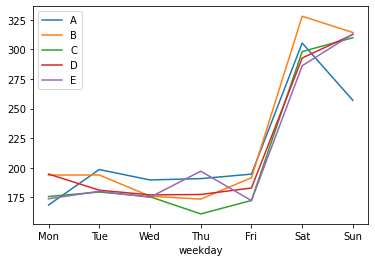

In [102]:
usage_history2['weekday'] = usage_history2['date'].dt.weekday
weekday_table = usage_history2.groupby(['weekday']).mean()[['A', 'B', 'C', 'D', 'E']]
weekday_table.plot()
plt.xticks([i for i in range(7)], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

### 3-3. 요일별 각 유형의 평균 전력 사용량 간에 연관성이 있는지 검정하라

In [90]:
weekday_table

,A,B,C,D,E
weekday,,,,,
0,168.436118,193.759166,175.623832,194.611378,173.696414
1,198.435064,193.830226,179.424797,180.975285,180.063460
2,189.627603,175.895540,175.419747,177.002098,174.973855
3,190.748404,173.421020,160.904972,177.331279,197.029684
4,194.546056,191.467902,172.280723,182.812973,172.166683
5,305.397108,328.048667,298.182008,292.749169,286.174977
6,256.929379,314.288336,309.893995,312.615013,313.091993


In [92]:
from scipy.stats import chi2_contingency
result=chi2_contingency(observed=weekday_table, correction=False, lambda_='pearson') 
print("1. 카이제곱 통계량: {:.2f}".format(result[0]))
print("2. p-value: {:.2f}".format(result[1]))
# 요일별 각 유형의 평균전력 사용량 간에 연관성이 없다. (귀무가설)

1. 카이제곱 통계량: 20.94
2. p-value: 0.64


### 3-4. 일자(매일)마다 각 유형의 전력사용량의 합을 데이터프레임으로 구하고 일자 데이터에서의 유형별 온도와의 상관계수를 각각 구하여라

In [109]:
usage_history2 = usage_history2.set_index('date')
usage_history3 = usage_history2.resample('D').sum()[['A', 'B', 'C', 'D', 'E']].reset_index()
usage_history3

,date,A,B,C,D,E
0,2050-01-01,1583.1230,1748.4258,719.0734,1512.2236,304.6623
1,2050-01-02,1084.4828,2167.1320,1227.6223,484.2982,1095.9014
2,2050-01-03,152.3612,394.0491,321.2149,982.0407,498.5167
3,2050-01-04,1225.0208,769.0568,655.4110,791.3395,834.6589
4,2050-01-05,836.8017,552.5661,1216.6259,1042.4509,666.6004
...,...,...,...,...,...,...
360,2050-12-27,1131.9901,944.7511,378.1692,438.1096,785.5438
361,2050-12-28,1114.3264,625.4472,1008.9049,914.4681,452.7479
362,2050-12-29,990.3719,776.5802,1085.4244,815.7627,367.3374
363,2050-12-30,1463.7257,908.3342,655.1917,539.5316,852.7281


In [112]:
from pandas import merge
avg_temp['date'] = avg_temp['date'].astype('datetime64')
merged = merge(usage_history3, avg_temp, on = 'date', how='left')
merged

,date,A,B,C,D,E,temperature
0,2050-01-01,1583.1230,1748.4258,719.0734,1512.2236,304.6623,6.164408
1,2050-01-02,1084.4828,2167.1320,1227.6223,484.2982,1095.9014,1.015510
2,2050-01-03,152.3612,394.0491,321.2149,982.0407,498.5167,3.691252
3,2050-01-04,1225.0208,769.0568,655.4110,791.3395,834.6589,4.071515
4,2050-01-05,836.8017,552.5661,1216.6259,1042.4509,666.6004,0.609249
...,...,...,...,...,...,...,...
360,2050-12-27,1131.9901,944.7511,378.1692,438.1096,785.5438,6.588207
361,2050-12-28,1114.3264,625.4472,1008.9049,914.4681,452.7479,3.201014
362,2050-12-29,990.3719,776.5802,1085.4244,815.7627,367.3374,0.670169
363,2050-12-30,1463.7257,908.3342,655.1917,539.5316,852.7281,0.141069


In [114]:
from scipy.stats import pearsonr
for TYPE in ['A', 'B', 'C', 'D', 'E']:
    rstat, p = pearsonr(merged[TYPE], merged['temperature'])
    print("Power consumption {} - Temperature: {:.2f} (p-value {:.2f})".format(TYPE, rstat, p))
# 모든 유형에서 상관관계가 보이지 않았다.

Power consumption A - Temperature: 0.00 (p-value 0.98)
Power consumption B - Temperature: -0.05 (p-value 0.36)
Power consumption C - Temperature: 0.05 (p-value 0.38)
Power consumption D - Temperature: -0.01 (p-value 0.85)
Power consumption E - Temperature: 0.07 (p-value 0.16)
